In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Random Forest

As we have seen, deep decision trees have low bias but a high variance (so performs well on our trainin gset but fails to generalize). One approach to address this issue is bagging.

## Bagging

Bagging, also called bootstrap aggregating reduces by variance and help to avoid overfitting. From a training set $Z$ of size $N$, bagging generates a new training set $Z_b$ by smapling from $Z$ uniformly with replacement. The chance that a training sample $x^{(i)}$ won't be included in the bootstrap sample $Z_b$ is:

$$
P(x^{(i)} \not\in Z_b) = (1 - \frac{1}{N})^N
$$

For large N this becomes:

$$
\lim_{N \to \infty} (1 - \frac{1}{N}) = \frac{1}{e}
$$

So in average, only a $(1 - 1/e) \approx 63.2\%$ fraction of unique training samples from $Z$ will be included in $Z_b$, the rest being duplicates. Bagging averages the prediction of multiple bootstrap samples $B$, so the estimate $f(x)$ is:

$$
f(x) = \frac{1}{B} \sum_{b=1}^{B} f_b(x)
$$

For classification problems, a majority voting is used. This reduces the variance of the model without increasing the bias. 

## Feature bagging

Random forests differ from pure bagging in one way: When training the decision trees, only a fraction of the available features are considered when looking for the best split. Several frameworks consider only a square root of features out of all available.

In [2]:
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor
)

class BaseRandomForest(object):

    def __init__(self, n_estimators=10, max_depth=None):
        self._n_estimators = n_estimators
        self._max_depth = max_depth
        self._estimators = []

    def _create_tree(self):
        raise NotImplementedError()

    def _all_predictions(self, X):
        return [estimator.predict(X) for estimator in self._estimators]

    def fit(self, X, y):
        samples = len(y)
        X = np.asarray(X)
        y = np.asarray(y)

        for _ in range(self._n_estimators):
            sample_indices = np.random.randint(0, samples, samples)
            train_X = X[sample_indices, :]
            train_y = y[sample_indices]
            estimator = self._create_tree().fit(train_X, train_y)
            self._estimators.append(estimator)

        return self

    def predict(self, X):
        raise NotImplementedError()


class RandomForestRegressor(BaseRandomForest):

    def _create_tree(self):
        return DecisionTreeRegressor(
            max_depth=self._max_depth,
            max_features='sqrt'
        )

    def predict(self, X):
        return np.mean(self._all_predictions(X), axis=0)


class RandomForestClassifier(BaseRandomForest):

    def _create_tree(self):
        return DecisionTreeClassifier(
            max_depth=self._max_depth,
            max_features='sqrt'
        )

    def predict(self, X):
        return np.argmax(np.bincount(self._all_predictions(X)))

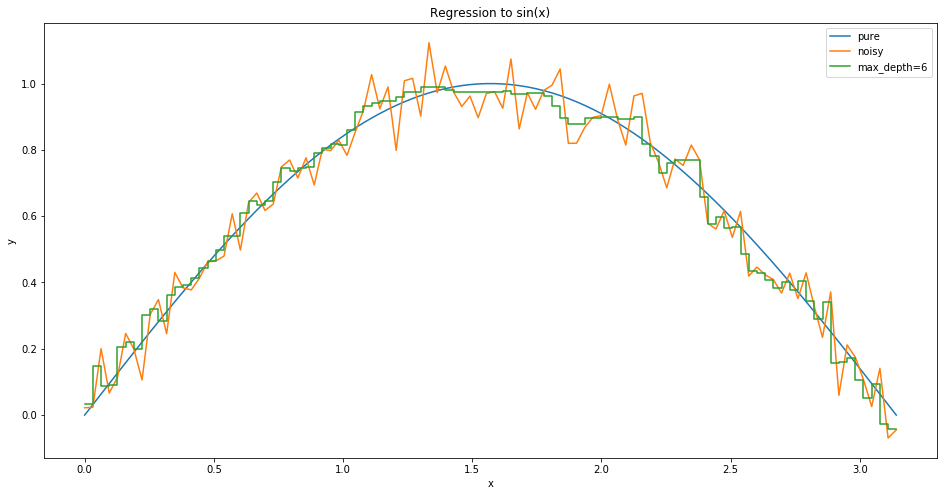

In [3]:
X = np.linspace(0, np.pi, 100).reshape(-1, 1)
y_pure = np.sin(X)
y_noisy = y_pure + np.random.normal(0, 0.07, X.shape)

fig, ax = plt.subplots()
ax.plot(X, y_pure, label='pure')
ax.plot(X, y_noisy, label='noisy')

max_depth = 6
y_predicted = RandomForestRegressor(max_depth=max_depth, n_estimators=20).fit(X, y_noisy).predict(X)
ax.step(X, y_predicted, label='max_depth={}'.format(max_depth))

ax.legend()
ax.set(
    xlabel='x',
    ylabel='y',
    title='Regression to sin(x)'
)
fig.set_size_inches(w=16, h=8)